In [31]:
import sys
sys.path.append('..')

RANDOM_STATE = 42

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the latest version
path = kagglehub.dataset_download(
  "habedi/developer-salary-survey-data-norway-2024",
)

df = pd.read_csv(path + "/salaries.csv")

# Rename columns
df.rename(columns={
    'kjønn': 'gender',
    'utdanning': 'edu level',
    'erfaring': 'experience',
    'arbeidssted': 'workplace',
    'lønn': 'salary',
    'arbeidssituasjon': 'work situation',
    'fag': 'work area',
    'bonus?': 'bonus'
}, inplace=True)

df.head()

,gender,edu level,experience,workplace,work situation,work area,salary,bonus
0,mann,4,7,Agder,"in-house, privat sektor",AI / maskinlæring,865000,Nei
1,mann,5,2,Nordland,"in-house, offentlig/kommunal sektor",AI / maskinlæring,756000,Nei
2,mann,4,30,Oslo,konsulent,AI / maskinlæring,1500000,Nei
3,mann,5,25,Oslo,konsulent,AI / maskinlæring,1200000,Nei
4,mann,9,18,Oslo,"in-house, privat sektor",AI / maskinlæring,1200000,Nei


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682 entries, 0 to 2681
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          2682 non-null   object
 1   edu level       2682 non-null   int64 
 2   experience      2682 non-null   int64 
 3   workplace       2682 non-null   object
 4   work situation  2682 non-null   object
 5   work area       2682 non-null   object
 6   salary          2682 non-null   int64 
 7   bonus           2682 non-null   object
dtypes: int64(3), object(5)
memory usage: 167.8+ KB


In [5]:
df.describe()

,edu level,experience,salary
count,2682.000000,2682.000000,2.682000e+03
mean,4.127517,8.568606,8.980438e+05
std,2.842134,7.770099,2.882830e+05
min,0.000000,0.000000,3.000000e+05
25%,3.000000,3.000000,7.000000e+05
50%,3.000000,6.000000,8.500000e+05
75%,5.000000,13.000000,1.020000e+06
max,20.000000,44.000000,2.700000e+06


In [6]:
df.isnull().sum()

gender            0
edu level         0
experience        0
workplace         0
work situation    0
work area         0
salary            0
bonus             0
dtype: int64

EDA

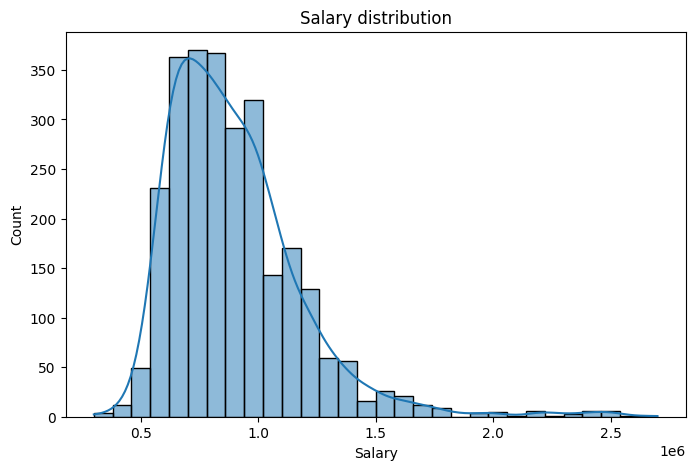

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df['salary'], kde=True, bins=30)
plt.title('Salary distribution')
plt.xlabel('Salary')
plt.ylabel('Count')
plt.show()

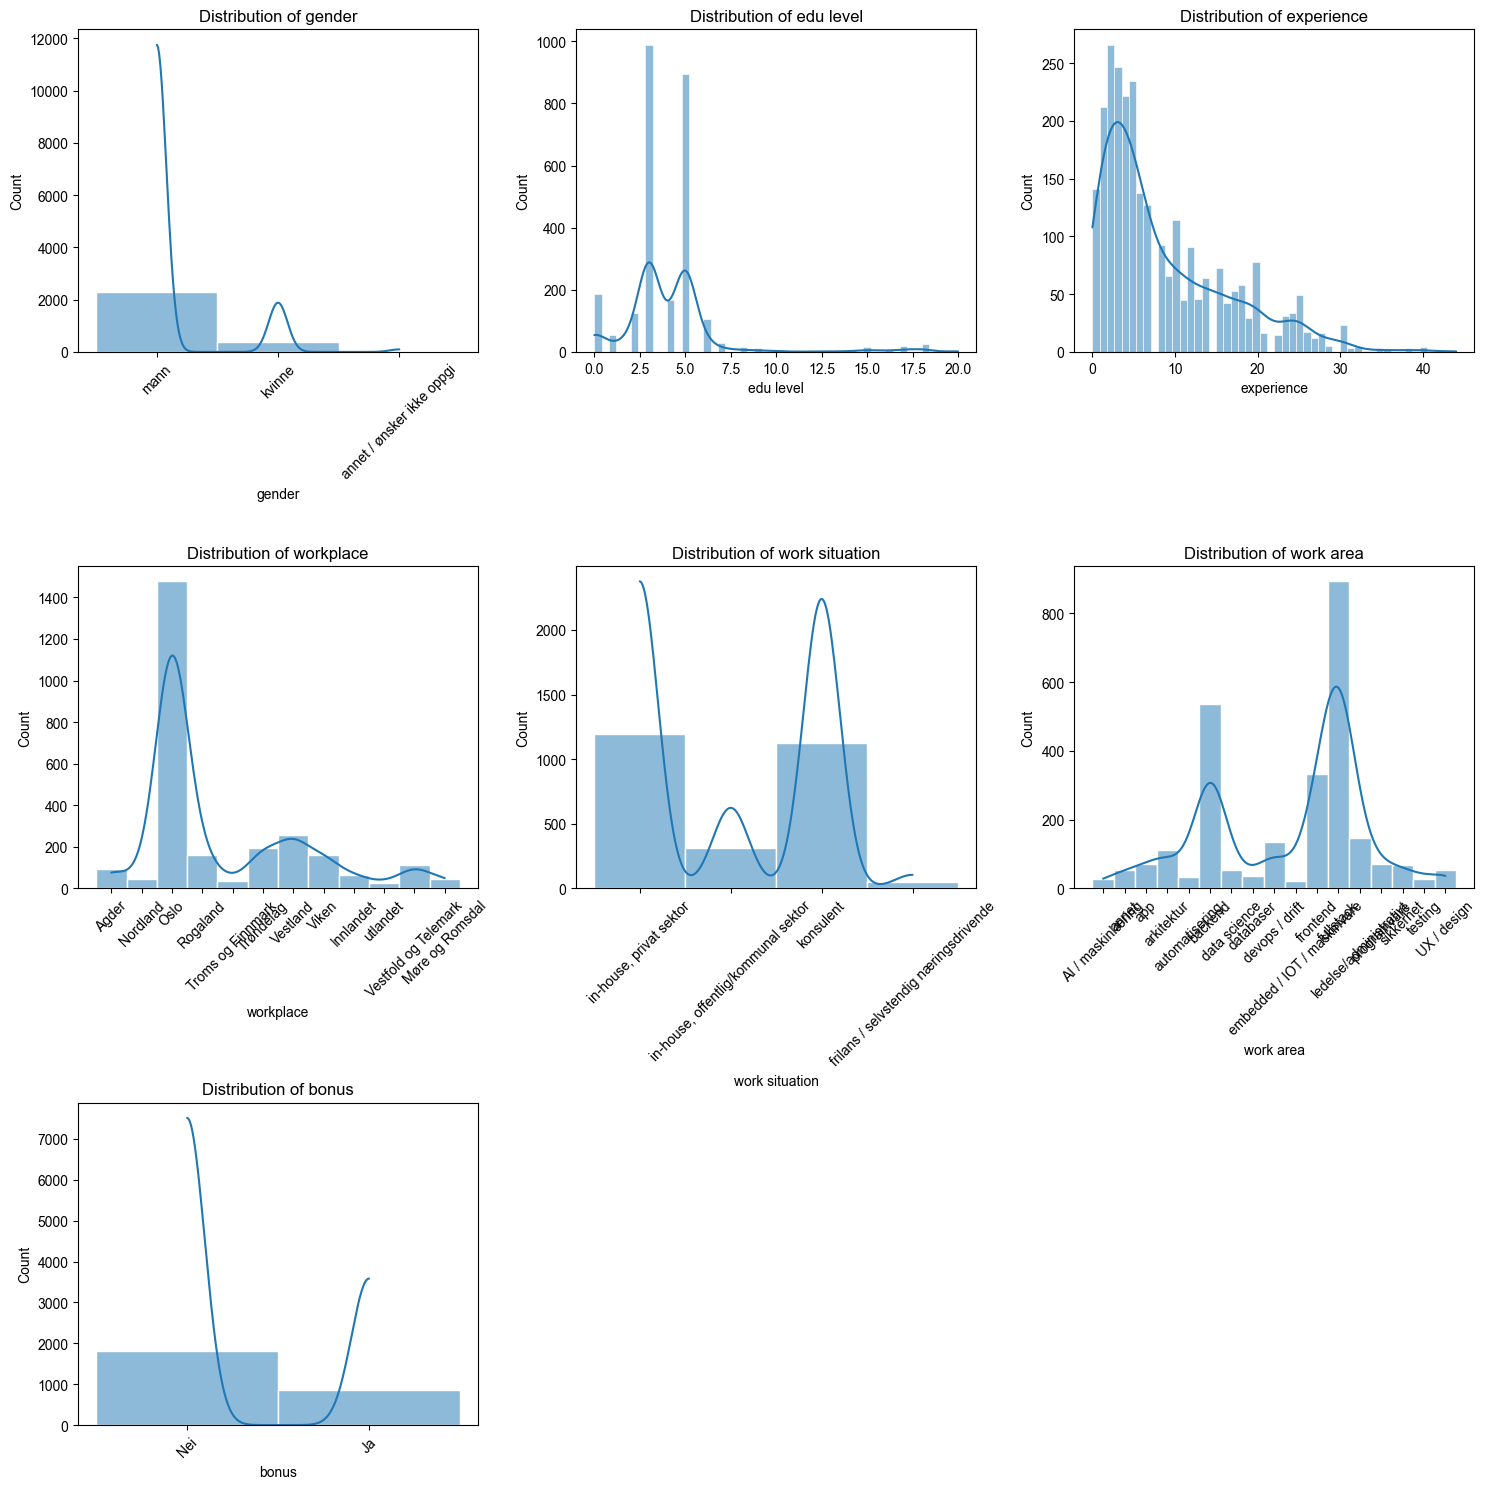

In [8]:
def plot_distributions(df, bins=50, figsize=None, kde=True):
    """Plots histograms for all columns in the DataFrame."""
    n_cols = df.shape[1]
    n_rows = (n_cols + 2) // 3  # 3 plots per row

    figsize = figsize or (15, 5 * n_rows)
    fig, axes = plt.subplots(n_rows, min(3, n_cols), figsize=figsize)

    sns.set_style("whitegrid")
    axes = np.array(axes).flatten() if n_cols > 1 else [axes]

    for col, ax in zip(df.columns, axes):
        sns.histplot(df[col], bins=bins, ax=ax, kde=kde)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        if df[col].dtype == 'object' or df[col].dtype == 'category':
            ax.tick_params(axis='x', rotation=45)

    for ax in axes[len(df.columns):]:  # Hide unused axes
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

plot_distributions(df.drop(columns=['salary']))


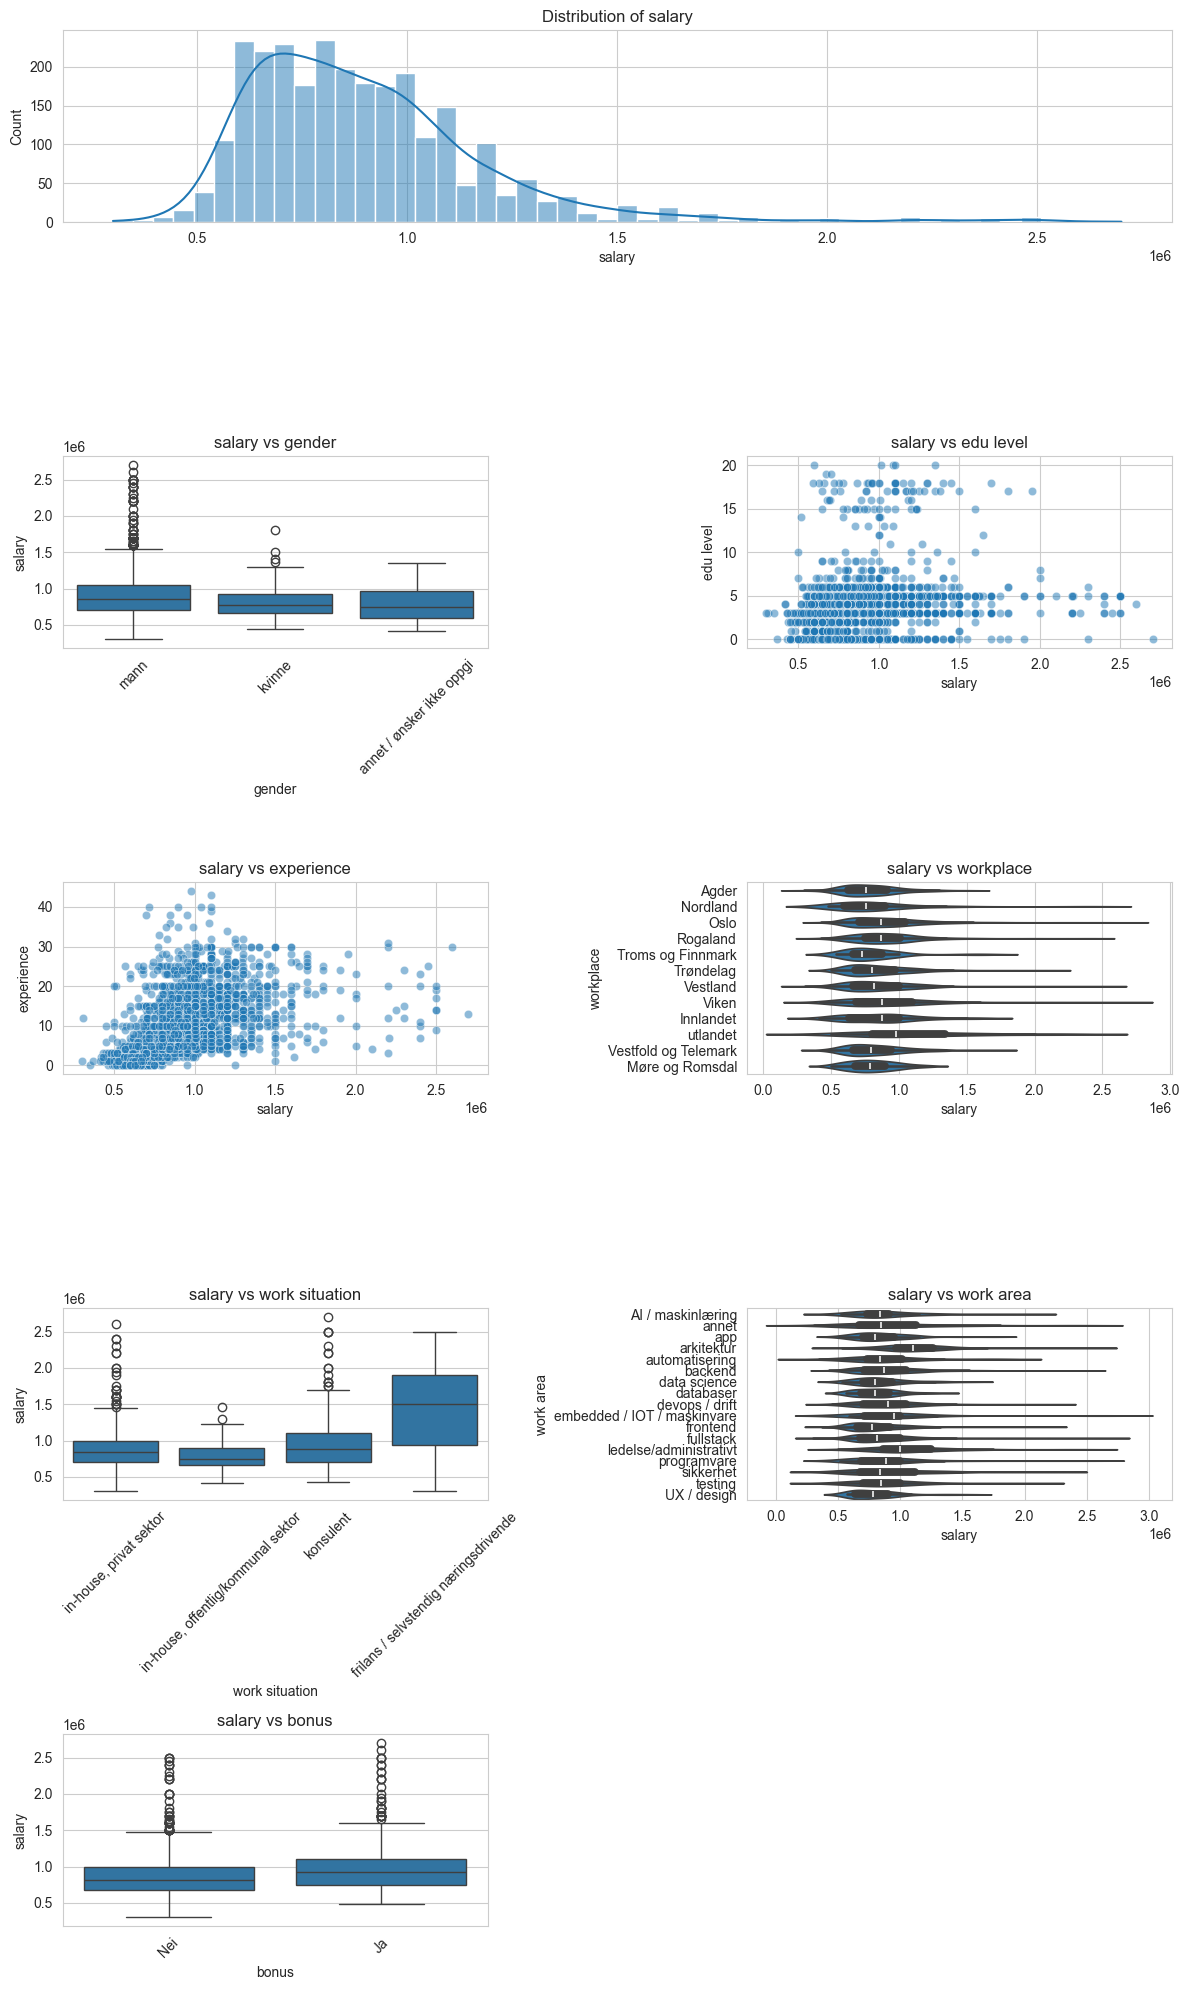

In [9]:
def plot_column_vs_all(df, target_column, bins=50, figsize=None):
    """Compares a target column against all others in the DataFrame."""
    other_cols = [col for col in df.columns if col != target_column]
    n_rows = (len(other_cols) + 1) // 2  # 2 plots per row

    figsize = figsize or (12, 4 + 4 * n_rows)
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(n_rows + 1, 2)
    
    ax_main = fig.add_subplot(gs[0, :])
    sns.histplot(df[target_column], bins=bins, ax=ax_main, kde=True)
    ax_main.set_title(f'Distribution of {target_column}')

    for idx, col in enumerate(other_cols):
        ax = fig.add_subplot(gs[(idx // 2) + 1, idx % 2])
        if np.issubdtype(df[target_column].dtype, np.number) and np.issubdtype(df[col].dtype, np.number):
            sns.scatterplot(data=df, x=target_column, y=col, ax=ax, alpha=0.5)
        elif df[col].nunique() < 10:
            sns.boxplot(data=df, x=col, y=target_column, ax=ax)
            ax.tick_params(axis='x', rotation=45)
        else:
            sns.violinplot(data=df, x=target_column, y=col, ax=ax)
        ax.set_title(f'{target_column} vs {col}')

    plt.tight_layout()
    plt.show()

plot_column_vs_all(df, 'salary')

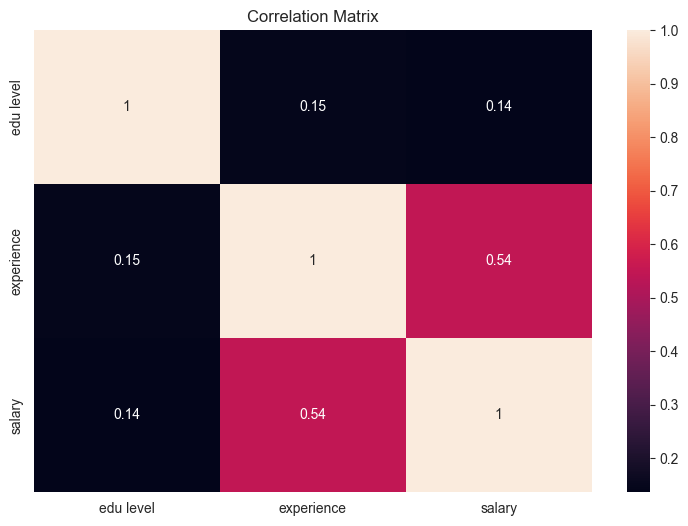

In [10]:
plt.figure(figsize=(9, 6))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

Preprocessing and Model Building

In [11]:
from utils.pipeline import build_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [ ]:
# Convert target variable to numeric values
le = LabelEncoder()
y = le.fit_transform(df['salary'])

X = df.drop(columns=['salary'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
scores = {}
    
pipe = build_pipeline(X)

In [13]:
# Linear Regression
lr_pipeline = pipe(LinearRegression())
lr_pipeline.fit(X_train, y_train)
scores['Linear Regression'] = lr_pipeline.score(X_test, y_test)

In [ ]:
# Decision Tree
tr_pipeline = pipe(DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE))
tr_pipeline.fit(X_train, y_train)
scores['Decision Tree'] = tr_pipeline.score(X_test, y_test)

In [ ]:
# Random Forest
rf_pipeline = pipe(RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE))
rf_pipeline.fit(X_train, y_train)
scores['Random Forest'] = rf_pipeline.score(X_test, y_test)

In [ ]:
# XGBoost
xgb_pipeline = pipe(xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=RANDOM_STATE))
xgb_pipeline.fit(X_train, y_train)
scores['XGBoost'] = xgb_pipeline.score(X_test, y_test)

In [ ]:
# LightGBM
lgbm_pipeline = pipe(lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=RANDOM_STATE, verbose=-1))
lgbm_pipeline.fit(X_train, y_train)
scores['LightGBM'] = lgbm_pipeline.score(X_test, y_test)

/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# CatBoost
cb_pipeline = pipe(CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, verbose=0, random_state=RANDOM_STATE))
cb_pipeline.fit(X_train, y_train)
scores['CatBoost'] = cb_pipeline.score(X_test, y_test)

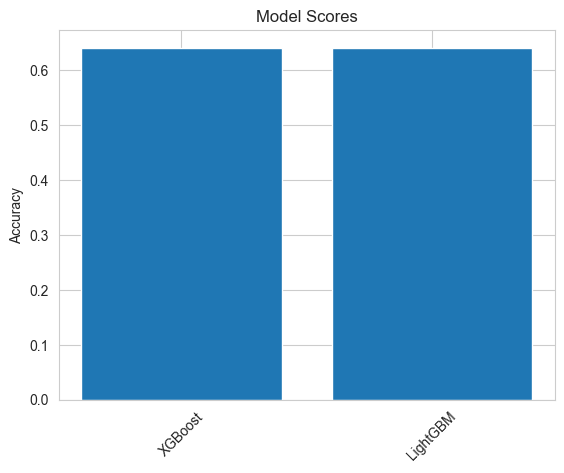

In [19]:
# Getting best two models
sorted_scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
top_2_scores = dict(list(sorted_scores.items())[:2])
plt.bar(top_2_scores.keys(), top_2_scores.values())
plt.title('Model Scores')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

Hyperparameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV
from utils.metrics import eval_regression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import optuna

Best parameters for XGBoost: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50}
Best score for XGBoost: 0.6272327542304993

Regression Metrics:
MAE: 54.5593
MSE: 5270.2412
RMSE: 72.5964
R² Score: 0.6345


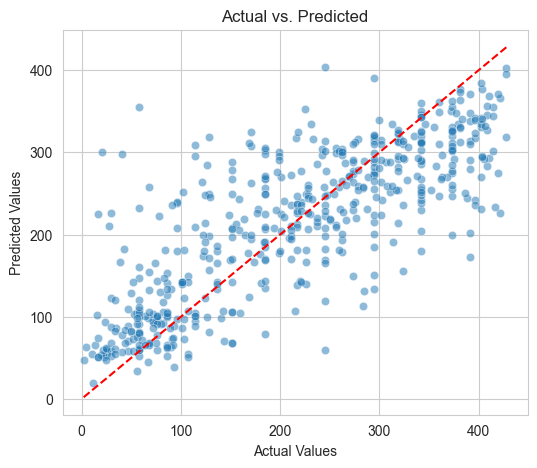

{'MAE': 54.559261322021484,
 'MSE': 5270.2412109375,
 'RMSE': 72.59642698464918,
 'R² Score': 0.6345258951187134}

In [21]:
# Grid search for XGBoost
xgb_param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {xgb_grid.best_params_}")
print(f"Best score for XGBoost: {xgb_grid.best_score_}")

eval_regression(xgb_grid, X_test, y_test)

/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

Best parameters for LightGBM: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50}
Best score for LightGBM: 0.6291854632207218

Regression Metrics:
MAE: 54.6676
MSE: 5281.7277
RMSE: 72.6755
R² Score: 0.6337


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


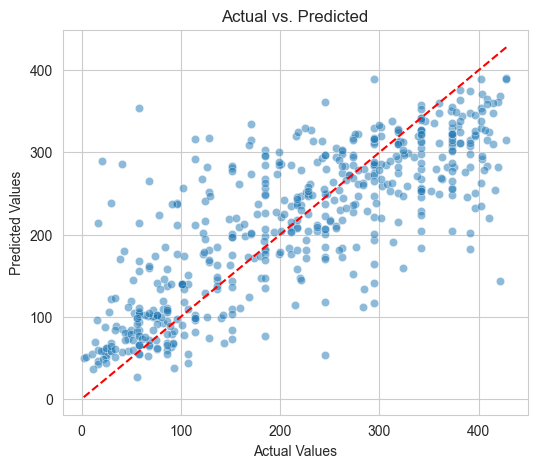

{'MAE': 54.66757299193702,
 'MSE': 5281.727725655087,
 'RMSE': 72.67549604684571,
 'R² Score': 0.6337293344621517}

In [22]:
# Grid search for LightGBM
lgbm_param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9]
}

lgbm_grid = GridSearchCV(lgbm_pipeline, lgbm_param_grid, cv=5, n_jobs=-1)
lgbm_grid.fit(X_train, y_train)

print(f"Best parameters for LightGBM: {lgbm_grid.best_params_}")
print(f"Best score for LightGBM: {lgbm_grid.best_score_}")

eval_regression(lgbm_grid, X_test, y_test)

In [ ]:
def get_optuna_scores(study):
    optuna_results = []
    for trial in study.trials:
        optuna_results.append({
            "Trial": trial.number,
            "n_estimators": trial.params.get("n_estimators"),
            "max_depth": trial.params.get("max_depth"),
            "Score": trial.value
        })

    optuna_results_df = pd.DataFrame(optuna_results)
    optuna_results_df = optuna_results_df.sort_values(by="Score", ascending=False)

    return optuna_results_df

In [ ]:
# Optuna for XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    model = pipe(xgb.XGBRegressor(**params, random_state=RANDOM_STATE))
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) 

get_optuna_scores(study)

[I 2025-03-05 19:52:06,433] A new study created in memory with name: no-name-2f43f4bd-a098-4848-bd74-00e3af8da9e0
[I 2025-03-05 19:52:06,683] Trial 0 finished with value: 0.626433253288269 and parameters: {'n_estimators': 91, 'learning_rate': 0.16425962542222453, 'max_depth': 7}. Best is trial 0 with value: 0.626433253288269.
[I 2025-03-05 19:52:07,153] Trial 1 finished with value: 0.577358603477478 and parameters: {'n_estimators': 174, 'learning_rate': 0.2360717539197726, 'max_depth': 8}. Best is trial 0 with value: 0.626433253288269.
[I 2025-03-05 19:52:07,258] Trial 2 finished with value: 0.6400442123413086 and parameters: {'n_estimators': 53, 'learning_rate': 0.08772644362928192, 'max_depth': 5}. Best is trial 2 with value: 0.6400442123413086.
[I 2025-03-05 19:52:07,463] Trial 3 finished with value: 0.6066131591796875 and parameters: {'n_estimators': 68, 'learning_rate': 0.23213831143444016, 'max_depth': 8}. Best is trial 2 with value: 0.6400442123413086.
[I 2025-03-05 19:52:07,563

,Trial,n_estimators,max_depth,Accuracy
14,14,72,4,0.648172
22,22,67,4,0.645308
21,21,68,4,0.644422
16,16,105,4,0.641748
24,24,66,4,0.641744
12,12,52,5,0.640212
2,2,53,5,0.640044
26,26,88,4,0.639632
4,4,51,5,0.639519
17,17,106,3,0.638896


In [33]:
# Optuna for LightGBM
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    model = pipe(lgb.LGBMRegressor(**params, random_state=RANDOM_STATE))
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

get_optuna_scores(study)


[I 2025-03-05 19:59:51,648] A new study created in memory with name: no-name-57df5cea-7622-42c0-b0d5-4a4216dcf975
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-05 19:59:51,782] Trial 0 finished with value: 0.641840686880621 and parameters: {'n_estimators': 83, 'learning_rate': 0.2648001055493412, 'max_depth': 3}. Best is trial 0 with value: 0.641840686880621.
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and 

,Trial,n_estimators,max_depth,Accuracy
13,13,88,3,0.642340
0,0,83,3,0.641841
15,15,74,4,0.641517
16,16,95,3,0.640910
27,27,65,3,0.640002
19,19,53,5,0.639706
24,24,66,3,0.639620
21,21,74,4,0.639520
22,22,74,3,0.639312
25,25,101,4,0.638526


In [ ]:
# Random Search for XGBoost
from scipy.stats import uniform

xgb_param_grid = {
    'model__n_estimators': randint(50, 150),
    'model__learning_rate': uniform(0.01, 0.19),
    'model__max_depth': randint(3, 10)
}

xgb_random_search = RandomizedSearchCV(
    xgb_pipeline, param_distributions=xgb_param_grid, n_iter=30, cv=5, verbose=2,
    random_state=RANDOM_STATE, scoring="r2", n_jobs=-1
)

xgb_random_search.fit(X_train, y_train)

print(f"Best Parameters: {xgb_random_search.best_params_}")
print(f"Best Score: {xgb_random_search.best_score_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   0.0s
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   0.0s
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   0.0s
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   0.0s
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   0.0s
[CV] END model__learning_rate=0.14907884894416698, model__max_depth=7, model__n_estimators=70; total time=   0.0s
[CV] END model__learning_rate=0.14907884894416698, model__max_depth=7, model__n_estimators=70; total time=   0.0s
[CV] END model__learning_rate=0.14907884894416698, model__max_depth=7, model__n_estimators=70; total time=   0.0s
[CV] END model__learning_r

In [45]:
# Random Search for LightGBM
lgbm_param_grid = {
    'model__n_estimators': randint(50, 150),
    'model__learning_rate': uniform(0.01, 0.19),
    'model__max_depth': randint(3, 10)
}

lgbm_random_search = RandomizedSearchCV(
    lgbm_pipeline, param_distributions=lgbm_param_grid, n_iter=30, cv=5, verbose=2,
    random_state=RANDOM_STATE, scoring="r2", n_jobs=-1
)

lgbm_random_search.fit(X_train, y_train)

print(f"Best Parameters: {lgbm_random_search.best_params_}")
print(f"Best Score: {lgbm_random_search.best_score_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.14907884894416698, model__max_depth=7, model__n_estimators=70; total time=   1.4s
[CV] END model__learning_rate=0.14907884894416698, model__max_depth=7, model__n_estimators=70; total time=   1.5s
[CV] END model__learning_rate=0.14907884894416698, model__max_depth=7, model__n_estimators=70; total time=   1.5s
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   1.6s
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   1.6s
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   1.6s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   1.7s
[CV] END model__learning_rate=0.08116262258099886, model__max_depth=7, model__n_estimators=64; total time=   1.7s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.14907884894416698, model__max_depth=7, model__n_estimators=70; total time=   1.2s
[CV] END model__learning_rate=0.14907884894416698, model__max_depth=7, model__n_estimators=70; total time=   1.4s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.039643541684062936, model__max_depth=5, model__n_estimators=136; total time=   2.0s
[CV] END model__learning_rate=0.039643541684062936, model__max_depth=5, model__n_estimators=136; total time=   2.0s
[CV] END model__learning_rate=0.039643541684062936, model__max_depth=5, model__n_estimators=136; total time=   2.1s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.039643541684062936, model__max_depth=5, model__n_estimators=136; total time=   2.2s
[CV] END model__learning_rate=0.039643541684062936, model__max_depth=5, model__n_estimators=136; total time=   2.4s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.03714469540516875, model__max_depth=5, model__n_estimators=71; total time=   1.5s
[CV] END model__learning_rate=0.03714469540516875, model__max_depth=5, model__n_estimators=71; total time=   1.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.03714469540516875, model__max_depth=5, model__n_estimators=71; total time=   1.4s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.021035886311957897, model__max_depth=7, model__n_estimators=149; total time=   4.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.03714469540516875, model__max_depth=5, model__n_estimators=71; total time=   1.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.03714469540516875, model__max_depth=5, model__n_estimators=71; total time=   1.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.021035886311957897, model__max_depth=7, model__n_estimators=149; total time=   4.7s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.021035886311957897, model__max_depth=7, model__n_estimators=149; total time=   4.1s
[CV] END model__learning_rate=0.021035886311957897, model__max_depth=7, model__n_estimators=149; total time=   4.9s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.020718200015149048, model__max_depth=6, model__n_estimators=79; total time=   2.5s
[CV] END model__learning_rate=0.021035886311957897, model__max_depth=7, model__n_estimators=149; total time=   4.4s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.020718200015149048, model__max_depth=6, model__n_estimators=79; total time=   2.0s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.020718200015149048, model__max_depth=6, model__n_estimators=79; total time=   2.2s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.020718200015149048, model__max_depth=6, model__n_estimators=79; total time=   2.4s
[CV] END model__learning_rate=0.05034443102887247, model__max_depth=6, model__n_estimators=70; total time=   1.7s
[CV] END model__learning_rate=0.05034443102887247, model__max_depth=6, model__n_estimators=70; total time=   1.5s
[CV] END model__learning_rate=0.12732148682926614, model__max_depth=4, model__n_estimators=71; total time=   0.6s
[CV] END model__learning_rate=0.020718200015149048, model__max_depth=6, model__n_estimators=79; total time=   2.1s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.05034443102887247, model__max_depth=6, model__n_estimators=70; total time=   1.7s
[CV] END model__learning_rate=0.05034443102887247, model__max_depth=6, model__n_estimators=70; total time=   1.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.12732148682926614, model__max_depth=4, model__n_estimators=71; total time=   0.5s
[CV] END model__learning_rate=0.05034443102887247, model__max_depth=6, model__n_estimators=70; total time=   1.6s
[CV] END model__learning_rate=0.12732148682926614, model__max_depth=4, model__n_estimators=71; total time=   0.5s
[CV] END model__learning_rate=0.12732148682926614, model__max_depth=4, model__n_estimators=71; total time=   0.5s
[CV] END model__learning_rate=0.12732148682926614, model__max_depth=4, model__n_estimators=71; total time=   0.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.011342597991746308, model__max_depth=3, model__n_estimators=98; total time=   0.5s
[CV] END model__learning_rate=0.011342597991746308, model__max_depth=3, model__n_estimators=98; total time=   0.6s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.011342597991746308, model__max_depth=3, model__n_estimators=98; total time=   0.5s
[CV] END model__learning_rate=0.011342597991746308, model__max_depth=3, model__n_estimators=98; total time=   0.7s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.011342597991746308, model__max_depth=3, model__n_estimators=98; total time=   0.7s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.10970718544909393, model__max_depth=9, model__n_estimators=91; total time=   2.0s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.10970718544909393, model__max_depth=9, model__n_estimators=91; total time=   2.2s
[CV] END model__learning_rate=0.10970718544909393, model__max_depth=9, model__n_estimators=91; total time=   2.3s
[CV] END model__learning_rate=0.10970718544909393, model__max_depth=9, model__n_estimators=91; total time=   2.2s
[CV] END model__learning_rate=0.10970718544909393, model__max_depth=9, model__n_estimators=91; total time=   2.2s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.01886647601058693, model__max_depth=6, model__n_estimators=129; total time=   3.4s
[CV] END model__learning_rate=0.01886647601058693, model__max_depth=6, model__n_estimators=129; total time=   3.4s
[CV] END model__learning_rate=0.01886647601058693, model__max_depth=6, model__n_estimators=129; total time=   3.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.054226554681757806, model__max_depth=8, model__n_estimators=96; total time=   2.3s
[CV] END model__learning_rate=0.054226554681757806, model__max_depth=8, model__n_estimators=96; total time=   2.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.054226554681757806, model__max_depth=8, model__n_estimators=96; total time=   2.6s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.12749334177328658, model__max_depth=6, model__n_estimators=104; total time=   1.6s
[CV] END model__learning_rate=0.01886647601058693, model__max_depth=6, model__n_estimators=129; total time=   3.2s
[CV] END model__learning_rate=0.01886647601058693, model__max_depth=6, model__n_estimators=129; total time=   3.4s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.19681386830328976, model__max_depth=3, model__n_estimators=52; total time=   0.3s
[CV] END model__learning_rate=0.19681386830328976, model__max_depth=3, model__n_estimators=52; total time=   0.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.054226554681757806, model__max_depth=8, model__n_estimators=96; total time=   2.3s
[CV] END model__learning_rate=0.19681386830328976, model__max_depth=3, model__n_estimators=52; total time=   0.3s
[CV] END model__learning_rate=0.054226554681757806, model__max_depth=8, model__n_estimators=96; total time=   2.4s
[CV] END model__learning_rate=0.19681386830328976, model__max_depth=3, model__n_estimators=52; total time=   0.4s
[CV] END model__learning_rate=0.12749334177328658, model__max_depth=6, model__n_estimators=104; total time=   1.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.12749334177328658, model__max_depth=6, model__n_estimators=104; total time=   1.7s
[CV] END model__learning_rate=0.19681386830328976, model__max_depth=3, model__n_estimators=52; total time=   0.2s
[CV] END model__learning_rate=0.12749334177328658, model__max_depth=6, model__n_estimators=104; total time=   1.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.09559485787421317, model__max_depth=4, model__n_estimators=53; total time=   0.5s
[CV] END model__learning_rate=0.09559485787421317, model__max_depth=4, model__n_estimators=53; total time=   0.6s
[CV] END model__learning_rate=0.12749334177328658, model__max_depth=6, model__n_estimators=104; total time=   1.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.09559485787421317, model__max_depth=4, model__n_estimators=53; total time=   0.5s
[CV] END model__learning_rate=0.09559485787421317, model__max_depth=4, model__n_estimators=53; total time=   0.5s
[CV] END model__learning_rate=0.09559485787421317, model__max_depth=4, model__n_estimators=53; total time=   0.5s
[CV] END model__learning_rate=0.17338867727990093, model__max_depth=9, model__n_estimators=70; total time=   1.4s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.17338867727990093, model__max_depth=9, model__n_estimators=70; total time=   1.4s
[CV] END model__learning_rate=0.17338867727990093, model__max_depth=9, model__n_estimators=70; total time=   1.4s
[CV] END model__learning_rate=0.17338867727990093, model__max_depth=9, model__n_estimators=70; total time=   1.4s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.17338867727990093, model__max_depth=9, model__n_estimators=70; total time=   1.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.18901833358012204, model__max_depth=8, model__n_estimators=58; total time=   1.2s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.18901833358012204, model__max_depth=8, model__n_estimators=58; total time=   1.2s
[CV] END model__learning_rate=0.18901833358012204, model__max_depth=8, model__n_estimators=58; total time=   1.3s
[CV] END model__learning_rate=0.18901833358012204, model__max_depth=8, model__n_estimators=58; total time=   1.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.18901833358012204, model__max_depth=8, model__n_estimators=58; total time=   1.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.013033587921840697, model__max_depth=4, model__n_estimators=133; total time=   1.8s
[CV] END model__learning_rate=0.013033587921840697, model__max_depth=4, model__n_estimators=133; total time=   1.8s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.013033587921840697, model__max_depth=4, model__n_estimators=133; total time=   1.9s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.013033587921840697, model__max_depth=4, model__n_estimators=133; total time=   1.9s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.013033587921840697, model__max_depth=4, model__n_estimators=133; total time=   2.0s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.05579483854494223, model__max_depth=6, model__n_estimators=120; total time=   2.7s
[CV] END model__learning_rate=0.05579483854494223, model__max_depth=6, model__n_estimators=120; total time=   2.7s
[CV] END model__learning_rate=0.05579483854494223, model__max_depth=6, model__n_estimators=120; total time=   2.8s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.05579483854494223, model__max_depth=6, model__n_estimators=120; total time=   2.7s
[CV] END model__learning_rate=0.12589936497869797, model__max_depth=9, model__n_estimators=84; total time=   2.5s
[CV] END model__learning_rate=0.05579483854494223, model__max_depth=6, model__n_estimators=120; total time=   2.8s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.12589936497869797, model__max_depth=9, model__n_estimators=84; total time=   2.4s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.1827708763949686, model__max_depth=6, model__n_estimators=99; total time=   1.4s
[CV] END model__learning_rate=0.12589936497869797, model__max_depth=9, model__n_estimators=84; total time=   2.5s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.12589936497869797, model__max_depth=9, model__n_estimators=84; total time=   2.1s
[CV] END model__learning_rate=0.13587923402725657, model__max_depth=4, model__n_estimators=55; total time=   0.5s
[CV] END model__learning_rate=0.1827708763949686, model__max_depth=6, model__n_estimators=99; total time=   1.6s
[CV] END model__learning_rate=0.1827708763949686, model__max_depth=6, model__n_estimators=99; total time=   1.5s
[CV] END model__learning_rate=0.1827708763949686, model__max_depth=6, model__n_estimators=99; total time=   1.5s
[CV] END model__learning_rate=0.12589936497869797, model__max_depth=9, model__n_estimators=84; total time=   2.3s
[CV] END model__learning_rate=0.13587923402725657, model__max_depth=4, model__n_estimators=55; total time=   0.6s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.13587923402725657, model__max_depth=4, model__n_estimators=55; total time=   0.5s
[CV] END model__learning_rate=0.13587923402725657, model__max_depth=4, model__n_estimators=55; total time=   0.5s
[CV] END model__learning_rate=0.13587923402725657, model__max_depth=4, model__n_estimators=55; total time=   0.6s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.1827708763949686, model__max_depth=6, model__n_estimators=99; total time=   1.7s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.04950891594495588, model__max_depth=6, model__n_estimators=103; total time=   2.3s
[CV] END model__learning_rate=0.04950891594495588, model__max_depth=6, model__n_estimators=103; total time=   2.3s
[CV] END model__learning_rate=0.01594952556655613, model__max_depth=4, model__n_estimators=139; total time=   1.7s
[CV] END model__learning_rate=0.04950891594495588, model__max_depth=6, model__n_estimators=103; total time=   2.2s
[CV] END model__learning_rate=0.01594952556655613, model__max_depth=4, model__n_estimators=139; total time=   1.9s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.04950891594495588, model__max_depth=6, model__n_estimators=103; total time=   2.4s
[CV] END model__learning_rate=0.01594952556655613, model__max_depth=4, model__n_estimators=139; total time=   1.7s
[CV] END model__learning_rate=0.04950891594495588, model__max_depth=6, model__n_estimators=103; total time=   2.1s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.09545328534025548, model__max_depth=4, model__n_estimators=111; total time=   0.9s
[CV] END model__learning_rate=0.09545328534025548, model__max_depth=4, model__n_estimators=111; total time=   1.0s
[CV] END model__learning_rate=0.09545328534025548, model__max_depth=4, model__n_estimators=111; total time=   1.0s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.09545328534025548, model__max_depth=4, model__n_estimators=111; total time=   1.0s
[CV] END model__learning_rate=0.09545328534025548, model__max_depth=4, model__n_estimators=111; total time=   1.0s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.01594952556655613, model__max_depth=4, model__n_estimators=139; total time=   1.5s
[CV] END model__learning_rate=0.01594952556655613, model__max_depth=4, model__n_estimators=139; total time=   1.6s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.1860651845008209, model__max_depth=9, model__n_estimators=97; total time=   2.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.1860651845008209, model__max_depth=9, model__n_estimators=97; total time=   2.0s
[CV] END model__learning_rate=0.1860651845008209, model__max_depth=9, model__n_estimators=97; total time=   2.2s
[CV] END model__learning_rate=0.1860651845008209, model__max_depth=9, model__n_estimators=97; total time=   2.2s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.1860651845008209, model__max_depth=9, model__n_estimators=97; total time=   2.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.07204274607310872, model__max_depth=8, model__n_estimators=136; total time=   2.9s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.07204274607310872, model__max_depth=8, model__n_estimators=136; total time=   3.0s
[CV] END model__learning_rate=0.07204274607310872, model__max_depth=8, model__n_estimators=136; total time=   3.1s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.10895850940490649, model__max_depth=8, model__n_estimators=89; total time=   1.9s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.10895850940490649, model__max_depth=8, model__n_estimators=89; total time=   2.1s
[CV] END model__learning_rate=0.10895850940490649, model__max_depth=8, model__n_estimators=89; total time=   2.1s
[CV] END model__learning_rate=0.07204274607310872, model__max_depth=8, model__n_estimators=136; total time=   3.0s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.07204274607310872, model__max_depth=8, model__n_estimators=136; total time=   3.1s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.10895850940490649, model__max_depth=8, model__n_estimators=89; total time=   2.2s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.17046143124884877, model__max_depth=7, model__n_estimators=131; total time=   2.1s
[CV] END model__learning_rate=0.10895850940490649, model__max_depth=8, model__n_estimators=89; total time=   2.1s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.11254150515392515, model__max_depth=4, model__n_estimators=138; total time=   1.3s
[CV] END model__learning_rate=0.11254150515392515, model__max_depth=4, model__n_estimators=138; total time=   1.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline

[CV] END model__learning_rate=0.17046143124884877, model__max_depth=7, model__n_estimators=131; total time=   2.7s
[CV] END model__learning_rate=0.11254150515392515, model__max_depth=4, model__n_estimators=138; total time=   1.2s
[CV] END model__learning_rate=0.17046143124884877, model__max_depth=7, model__n_estimators=131; total time=   2.3s
[CV] END model__learning_rate=0.17046143124884877, model__max_depth=7, model__n_estimators=131; total time=   2.6s
[CV] END model__learning_rate=0.11254150515392515, model__max_depth=4, model__n_estimators=138; total time=   1.3s


/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgijhabner/Desktop/awesome-ml-pipeline/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END model__learning_rate=0.17046143124884877, model__max_depth=7, model__n_estimators=131; total time=   2.5s
[CV] END model__learning_rate=0.11254150515392515, model__max_depth=4, model__n_estimators=138; total time=   0.6s
Best Parameters: {'model__learning_rate': 0.19681386830328976, 'model__max_depth': 3, 'model__n_estimators': 52}
Best Score: 0.6276471848798562
